<a href="https://colab.research.google.com/github/TEQUILA009/Machine-Learning/blob/master/Stock_Market_Prediction_Using_Numerical_and_Textual_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
 
import math
import pandas as pd
import numpy as npp
 
import matplotlib.pyplot as plt
import seaborn as sns
 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
 
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
 
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
for i in ['gutenberg','punkt','vader_lexicon']:              
  nltk.download(str(i))
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vader
print('Libraries Imported')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
Libraries Imported


In [2]:
stock_price=pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=978307200&period2=1602979200&interval=1d&events=history&includeAdjustedClose=true')
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


In [3]:
# As the headlines dataset was given to us offline and it took really long to upload on collab I had to first mount my dataset on Gdrive and then acess it from there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ls

drive/  sample_data/


In [5]:
cd drive/MyDrive/


/content/drive/MyDrive


In [6]:
stock_headlines = pd.read_csv('india-news-headlines.csv')  
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [7]:
# Displaying number of records in both stock_price and stock_headlines datasets
len(stock_headlines), len(stock_price)

(3297172, 4980)

In [8]:
# Checking for null values in both the datasets
stock_headlines.isna().any(), stock_price.isna().any()

(publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool, Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool)

In [9]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,1283.270020,1320.280029,1320.280029,1276.050049,1129400000
2001-01-03,1347.560059,1283.270020,1347.760010,1274.619995,1880700000
2001-01-04,1333.339966,1347.560059,1350.239990,1329.140015,2131000000
2001-01-05,1298.349976,1333.339966,1334.770020,1294.949951,1430800000
2001-01-08,1295.859985,1298.349976,1298.349976,1276.290039,1115500000
...,...,...,...,...,...
2020-10-12,3534.219971,3500.020020,3549.850098,3499.610107,3428970000
2020-10-13,3511.929932,3534.010010,3534.010010,3500.860107,3605150000
2020-10-14,3488.669922,3515.469971,3527.939941,3480.550049,3840630000


In [10]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


In [11]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data


,Close,Open,High,Low,Volume,headline_text
2001-01-02,1283.270020,1320.280029,1320.280029,1276.050049,1.129400e+09,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,1347.560059,1283.270020,1347.760010,1274.619995,1.880700e+09,"Powerless north India gropes in the dark,Think..."
2001-01-04,1333.339966,1347.560059,1350.239990,1329.140015,2.131000e+09,The string that pulled Stephen Hawking to Indi...
2001-01-05,1298.349976,1333.339966,1334.770020,1294.949951,1.430800e+09,Light combat craft takes India into club class...
2001-01-08,1295.859985,1298.349976,1298.349976,1276.290039,1.115500e+09,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2020-06-24,3050.330078,3114.399902,3115.010010,3032.129883,5.587200e+09,I never thought I had a voice until today: Vid...
2020-06-25,3083.760010,3046.600098,3086.250000,3024.010010,4.815420e+09,Truck firms look for new export markets to sel...
2020-06-26,3009.050049,3073.199951,3073.729980,3004.629883,8.098120e+09,Containment zone residents slam high prices ch...
2020-06-29,3053.239990,3018.590088,3053.889893,2999.739990,4.462770e+09,6 hot and stylish bikini looks of Katrina Kaif...


In [12]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,1283.270020,1320.280029,1320.280029,1276.050049,1.129400e+09,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,1347.560059,1283.270020,1347.760010,1274.619995,1.880700e+09,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,1333.339966,1347.560059,1350.239990,1329.140015,2.131000e+09,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,1298.349976,1333.339966,1334.770020,1294.949951,1.430800e+09,Light combat craft takes India into club class...,,,,
2001-01-08,1295.859985,1298.349976,1298.349976,1276.290039,1.115500e+09,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [13]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,1283.270020,1320.280029,1320.280029,1276.050049,1.129400e+09,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,1347.560059,1283.270020,1347.760010,1274.619995,1.880700e+09,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,1333.339966,1347.560059,1350.239990,1329.140015,2.131000e+09,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,1298.349976,1333.339966,1334.770020,1294.949951,1.430800e+09,Light combat craft takes India into club class...,0.9032,0.105,0.746,0.149
2001-01-08,1295.859985,1298.349976,1298.349976,1276.290039,1.115500e+09,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


In [14]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,1283.270020,-0.9621,0.119,0.817,0.064,1320.280029,1320.280029,1276.050049,1.129400e+09
2001-01-03,1347.560059,0.6322,0.084,0.817,0.098,1283.270020,1347.760010,1274.619995,1.880700e+09
2001-01-04,1333.339966,0.6648,0.077,0.843,0.080,1347.560059,1350.239990,1329.140015,2.131000e+09
2001-01-05,1298.349976,0.9032,0.105,0.746,0.149,1333.339966,1334.770020,1294.949951,1.430800e+09
2001-01-08,1295.859985,-0.9638,0.119,0.855,0.026,1298.349976,1298.349976,1276.290039,1.115500e+09


In [15]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

In [16]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,1283.270020,-0.9621,0.119,0.817,0.064,1320.280029,1320.280029,1276.050049,1.129400e+09
2001-01-03,1347.560059,0.6322,0.084,0.817,0.098,1283.270020,1347.760010,1274.619995,1.880700e+09
2001-01-04,1333.339966,0.6648,0.077,0.843,0.080,1347.560059,1350.239990,1329.140015,2.131000e+09
2001-01-05,1298.349976,0.9032,0.105,0.746,0.149,1333.339966,1334.770020,1294.949951,1.430800e+09
2001-01-08,1295.859985,-0.9638,0.119,0.855,0.026,1298.349976,1298.349976,1276.290039,1.115500e+09


In [17]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4877, 9)

In [18]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [19]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4.877000e+03
mean,1620.736061,-0.870185,0.125720,0.788116,0.086175,1620.504139,1629.706190,1610.499933,3.269558e+09
std,635.426465,0.453365,0.024431,0.033153,0.020881,635.419166,637.106093,633.367806,1.475082e+09
min,676.530029,-1.000000,0.000000,0.000000,0.000000,679.280029,695.270020,666.789978,3.560700e+08
25%,1145.599976,-0.999800,0.112000,0.768000,0.075000,1145.540039,1152.439941,1136.979980,2.079340e+09
50%,1358.040039,-0.999000,0.127000,0.785000,0.086000,1357.979980,1365.489990,1348.510010,3.327480e+09
75%,2063.500000,-0.994100,0.141000,0.806000,0.096000,2063.010010,2073.850098,2051.989990,4.025840e+09
max,3386.149902,1.000000,0.444000,1.000000,0.608000,3380.449951,3393.520020,3378.830078,1.145623e+10


In [20]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4877 entries, 2001-01-02 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4877 non-null   float64
 1   compound  4877 non-null   float64
 2   negative  4877 non-null   float64
 3   neutral   4877 non-null   float64
 4   positive  4877 non-null   float64
 5   Open      4877 non-null   float64
 6   High      4877 non-null   float64
 7   Low       4877 non-null   float64
 8   Volume    4877 non-null   float64
dtypes: float64(9)
memory usage: 381.0+ KB


Text(0, 0.5, 'Close Price ($)')

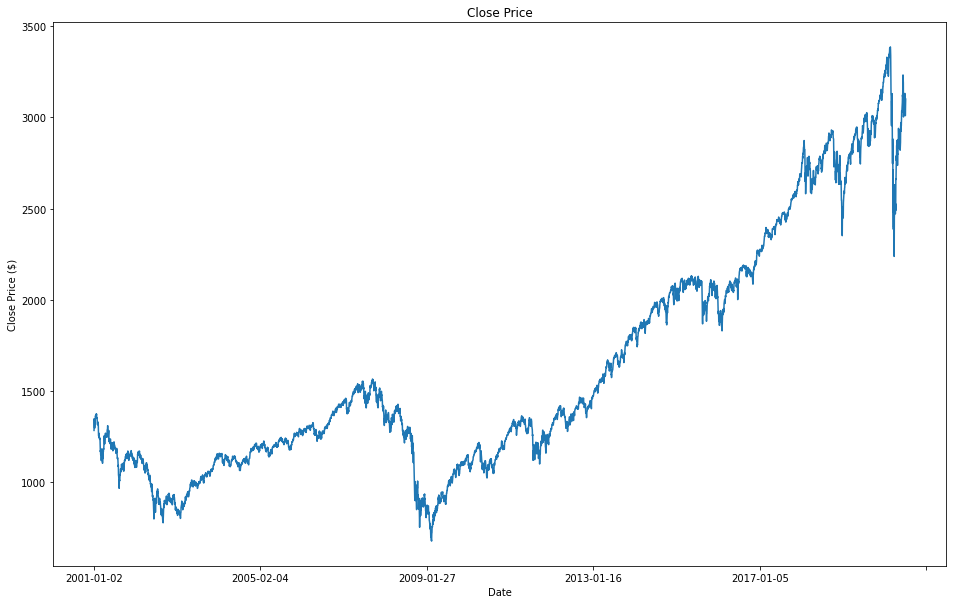

In [21]:

# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [22]:

# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,1310.350011,-0.179071,0.121714,0.810429,0.067571,1311.351441,1325.268572,1290.495728,1.453600e+09
2001-01-11,1316.571429,-0.041629,0.117857,0.810286,0.071571,1310.350011,1326.969988,1295.305716,1.493857e+09
2001-01-23,1318.405709,0.000843,0.111000,0.818429,0.070429,1318.868583,1329.132847,1304.592861,1.401271e+09


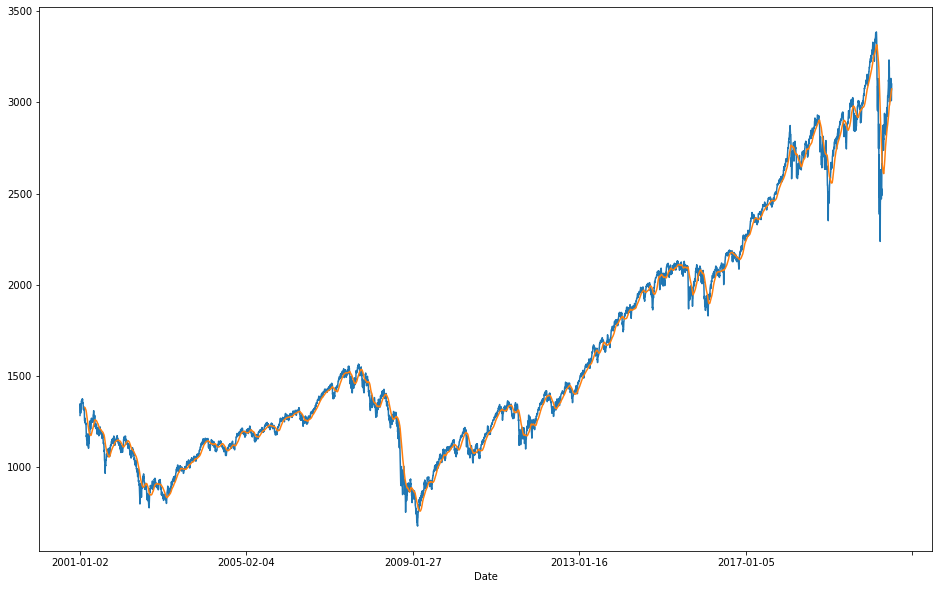

In [23]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [24]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,1283.270020,-0.9621,0.119,0.817,0.064,1320.280029,1320.280029,1276.050049,1.129400e+09
2001-01-03,1347.560059,0.6322,0.084,0.817,0.098,1283.270020,1347.760010,1274.619995,1.880700e+09
2001-01-04,1333.339966,0.6648,0.077,0.843,0.080,1347.560059,1350.239990,1329.140015,2.131000e+09
2001-01-05,1298.349976,0.9032,0.105,0.746,0.149,1333.339966,1334.770020,1294.949951,1.430800e+09
2001-01-08,1295.859985,-0.9638,0.119,0.855,0.026,1298.349976,1298.349976,1276.290039,1.115500e+09
...,...,...,...,...,...,...,...,...,...
2020-06-24,3050.330078,-0.9997,0.115,0.811,0.074,3114.399902,3115.010010,3032.129883,5.587200e+09
2020-06-25,3083.760010,-0.9999,0.126,0.820,0.054,3046.600098,3086.250000,3024.010010,4.815420e+09
2020-06-26,3009.050049,-0.9999,0.149,0.766,0.085,3073.199951,3073.729980,3004.629883,8.098120e+09


In [25]:

# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3900
Number of records in Test Data: 977


In [26]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-03    1347.560059
2001-01-04    1333.339966
2001-01-05    1298.349976
2001-01-08    1295.859985
2001-01-09    1300.800049
                 ...     
2020-06-24    3050.330078
2020-06-25    3083.760010
2020-06-26    3009.050049
2020-06-29    3053.239990
2020-06-30    3100.290039
Name: Close, Length: 4876, dtype: float64

In [27]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,1347.560059,1333.339966,0.6322,0.6648,1.880700e+09,1283.270020,1347.760010,1274.619995
2001-01-04,1333.339966,1298.349976,0.6648,0.9032,2.131000e+09,1347.560059,1350.239990,1329.140015
2001-01-05,1298.349976,1295.859985,0.9032,-0.9638,1.430800e+09,1333.339966,1334.770020,1294.949951
2001-01-08,1295.859985,1300.800049,-0.9638,-0.9559,1.115500e+09,1298.349976,1298.349976,1276.290039
2001-01-09,1300.800049,1313.270020,-0.9559,-0.5719,1.191300e+09,1295.859985,1311.719971,1295.140015
2001-01-10,1313.270020,1326.819946,-0.5719,0.0000,1.296500e+09,1300.800049,1313.760010,1287.280029
2001-01-11,1326.819946,1360.400024,0.0000,0.9295,1.411200e+09,1313.270020,1332.189941,1309.719971
2001-01-23,1360.400024,1364.300049,0.9295,-0.9039,1.232600e+09,1342.900024,1362.900024,1339.630005
2001-01-24,1364.300049,1357.510010,-0.9039,-0.9854,1.309000e+09,1360.400024,1369.750000,1357.280029


In [28]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-01-03    1333.339966
2001-01-04    1298.349976
2001-01-05    1295.859985
2001-01-08    1300.800049
2001-01-09    1313.270020
                 ...     
2020-06-23    3050.330078
2020-06-24    3083.760010
2020-06-25    3009.050049
2020-06-26    3053.239990
2020-06-29    3100.290039
Name: close_price_shifted, Length: 4875, dtype: float64

In [29]:

# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,1347.560059,0.6322,0.6648,1.880700e+09,1283.270020,1347.760010,1274.619995
2001-01-04,1333.339966,0.6648,0.9032,2.131000e+09,1347.560059,1350.239990,1329.140015
2001-01-05,1298.349976,0.9032,-0.9638,1.430800e+09,1333.339966,1334.770020,1294.949951
2001-01-08,1295.859985,-0.9638,-0.9559,1.115500e+09,1298.349976,1298.349976,1276.290039
2001-01-09,1300.800049,-0.9559,-0.5719,1.191300e+09,1295.859985,1311.719971,1295.140015
...,...,...,...,...,...,...,...
2020-06-23,3131.290039,-0.9999,-0.9997,4.704830e+09,3138.699951,3154.899902,3127.120117
2020-06-24,3050.330078,-0.9997,-0.9999,5.587200e+09,3114.399902,3115.010010,3032.129883
2020-06-25,3083.760010,-0.9999,-0.9999,4.815420e+09,3046.600098,3086.250000,3024.010010


In [31]:

# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = npp.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = npp.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.50470541,  0.6322    ,  0.6648    , ..., -0.55279378,
         -0.51636061, -0.5517544 ],
        [-0.51520142,  0.6648    ,  0.9032    , ..., -0.50519216,
         -0.5145224 , -0.51154849],
        [-0.54102791,  0.9032    , -0.9638    , ..., -0.515721  ,
         -0.52598907, -0.53676203],
        ...,
        [ 0.77680272, -0.9999    , -0.9999    , ...,  0.75281092,
          0.77224496,  0.73833715],
        [ 0.72165848, -0.9999    , -0.9997    , ...,  0.77250598,
          0.76296485,  0.72404523],
        [ 0.75427556, -0.9997    , -0.9998    , ...,  0.73207175,
          0.74825896,  0.72043917]]), array([[-0.51520142],
        [-0.54102791],
        [-0.5428658 ],
        ...,
        [ 0.72165848],
        [ 0.75427556],
        [ 0.78900372]]))

In [32]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3900, 7) and y: (3900, 1)
Number of rows and columns in the Test set X: (974, 7) and y: (974, 1)


In [33]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3900, 7, 1)
Shape of Test set X: (974, 7, 1)


In [34]:

# setting the seed to achieve consistent and less random predictions at each execution
npp.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [35]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)


Epoch 1/10
390/390 [==============================] - 3s 7ms/step - loss: 0.0216 - val_loss: 0.2158
Epoch 2/10
390/390 [==============================] - 2s 5ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 3/10
390/390 [==============================] - 2s 5ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 4/10
390/390 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 6.0412e-04
Epoch 5/10
390/390 [==============================] - 2s 5ms/step - loss: 0.0010 - val_loss: 3.5642e-04
Epoch 6/10
390/390 [==============================] - 2s 5ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/10
390/390 [==============================] - 2s 5ms/step - loss: 9.6657e-04 - val_loss: 5.0229e-04
Epoch 8/10
390/390 [==============================] - 2s 5ms/step - loss: 8.4031e-04 - val_loss: 9.1415e-04
Epoch 9/10
390/390 [==============================] - 2s 5ms/step - loss: 8.2223e-04 - val_loss: 8.7121e-04
Epoch 10/10
390/390 [==============================] - 2s 5ms/step -

In [36]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [37]:

# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(npp.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[2199.1272],
       [2195.0088],
       [2201.4543],
       [2196.035 ],
       [2192.0898]], dtype=float32)

In [38]:

# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

974/974 [==============================] - 2s 2ms/step - loss: 0.0024
Train Loss = 0.0003
Test Loss = 0.0024


In [39]:

# calculating root mean squared error
root_mean_square_error = npp.sqrt(npp.mean(npp.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 2753.0931


In [40]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(npp.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 2753.0931


In [41]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(npp.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(npp.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(npp.array(y_test).reshape((len(y_test), 1)))

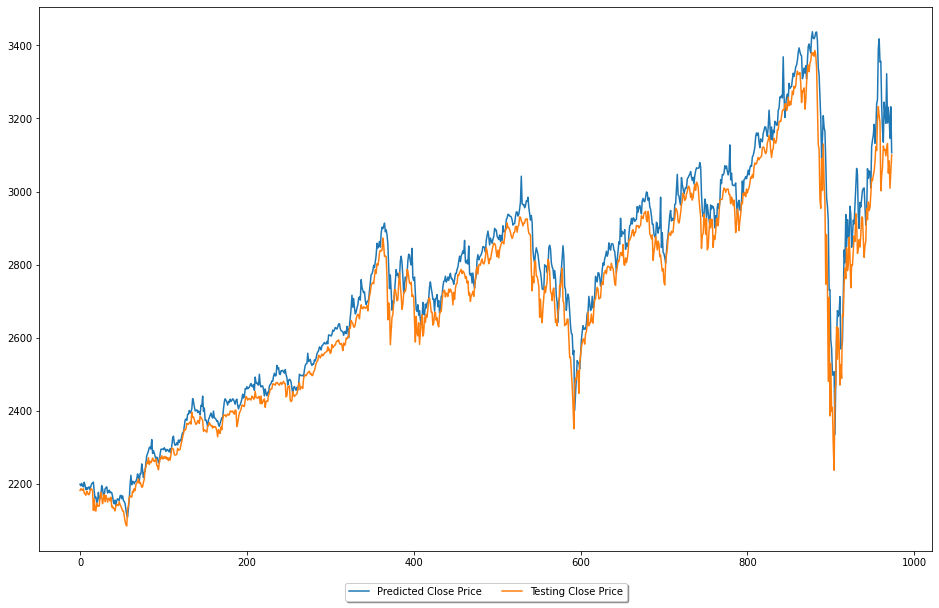

In [42]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()